In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from fancyimpute import mice
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, IterativeImputer, BiScaler
from sklearn.preprocessing import Imputer
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import math
import sklearn.metrics as sklm
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor



Using TensorFlow backend.


## The UN report 
Hunger cause by 3 main reason:
<ul>
   <li><p> 1.intensity of conflict, cause agricultural undernorishment</p></li>
    <li><p>2.extreme climatic change,compremise access to food</p></li>
    <li><p>3.economic slowdown,declining exporting commodity</p></li>
</ul>
## Heads Up

When you are doing your local train/test split, it is imperative that you split the data by country so that all years of data for a country appear either in the train set or the test set, but are not split across both. Otherwise, your model will simply interpolate between the known values in your train set rather than learning the underlying patterns in the data. The model will then score poorly when submitted as it will be evaluated on data from entirely different countries.

If your leaderboard score is significantly lower than your local score, it is likely because you have not split your data by country when training your model.

## step
<ul>
    <li><p>step1:separete categorical data and numeric data</p></li>
    <li><p>step2:remove duplicate</p></li>
    <li><p>step3:filling missing data</p></li>
    <li><p>step4:Correlation</p></li>
</ul>



In [2]:
pd.set_option('display.float_format',lambda x:'%.4f'%x)
df=pd.read_csv('../data/train_values_6tLXv3T.csv')
df_label=pd.read_csv('../data/train_labels.csv')
#add the 'Urban_population_share' columns
df['Urban_population_share']=df['urban_population']/df['total_population']
df['prevalence_of_undernourishment']=df_label['prevalence_of_undernourishment']

df.head()

,row_id,country_code,year,agricultural_land_area,percentage_of_arable_land_equipped_for_irrigation,cereal_yield,droughts_floods_extreme_temps,forest_area,total_land_area,fertility_rate,...,rail_lines_density,access_to_electricity,co2_emissions,unemployment_rate,total_labor_force,military_expenditure_share_gdp,proportion_of_seats_held_by_women_in_gov,political_stability,Urban_population_share,prevalence_of_undernourishment
0,0,889f053,2002,235077.6581,38.5585,935.7544,nan,5397.7375,537408.3125,5.9290,...,nan,52.4332,15485.1482,14.7880,4350520.5412,7.0211,0.6982,-1.3938,0.2691,31.2607
1,1,9e614ab,2012,23000.6407,21.2826,4031.4522,nan,178336.5299,232013.6317,3.0006,...,nan,77.7156,1696.4582,0.6870,3262614.2006,0.1988,25.1018,0.0306,0.3516,18.2982
2,2,100c476,2000,90.9549,4.3171,1581.9353,nan,101.7806,445.0371,2.3019,...,nan,91.1510,338.7952,nan,nan,nan,5.3954,0.6516,0.3195,39.5134
3,3,4609682,2013,100843.6612,16.6366,1127.6264,nan,10348.8669,154616.1482,2.1993,...,1.2771,99.0304,27377.8026,15.9484,3979141.3836,1.6263,26.7360,-0.9288,0.6502,4.4440
4,4,be2a7f5,2008,224.2894,nan,1418.9872,nan,460.1134,740.2957,nan,...,nan,91.9304,134.2581,nan,nan,nan,19.1368,0.9560,0.6696,4.9403


In [3]:
df.describe()

,row_id,year,agricultural_land_area,percentage_of_arable_land_equipped_for_irrigation,cereal_yield,droughts_floods_extreme_temps,forest_area,total_land_area,fertility_rate,life_expectancy,...,rail_lines_density,access_to_electricity,co2_emissions,unemployment_rate,total_labor_force,military_expenditure_share_gdp,proportion_of_seats_held_by_women_in_gov,political_stability,Urban_population_share,prevalence_of_undernourishment
count,1401.0000,1401.0000,1385.0000,1153.0000,1337.0000,75.0000,1385.0000,1401.0000,1387.0000,1386.0000,...,457.0000,1397.0000,1317.0000,1337.0000,1337.0000,1128.0000,1258.0000,1266.0000,1401.0000,1401.0000
mean,700.0000,2007.3926,353958.8331,27.8914,2753.1782,1.2368,232945.4829,818114.6457,3.2519,67.1141,...,1.1831,73.7954,83046.7077,8.5803,18712325.2157,1.9193,15.6185,-0.3760,0.4985,15.5107
std,404.5782,4.5955,1172377.2237,28.5776,2777.8151,1.8778,926633.3865,2792116.7253,1.4710,8.7869,...,1.1750,31.2803,224835.9632,6.6451,61123468.9339,1.4808,10.3243,0.8589,0.2144,11.6104
min,0.0000,2000.0000,2.9442,0.0000,179.2589,0.0000,9.8067,20.1831,0.8361,38.2041,...,0.0000,0.0100,100.8288,0.4911,34906.5902,0.0000,0.0000,-2.7813,0.0820,2.4934
25%,350.0000,2003.0000,11745.7681,3.4910,1424.5038,0.0974,4159.0051,25074.5972,2.1754,61.6780,...,0.2977,51.0623,1265.7785,3.7486,907680.9895,1.0339,8.5754,-0.9482,0.3249,5.7109
50%,700.0000,2007.0000,47019.7976,18.8462,2221.9210,0.6614,22241.7016,130944.2379,2.7516,69.8577,...,0.6082,89.1562,7637.9105,6.6335,3411047.6033,1.5381,13.0930,-0.2877,0.4863,12.1187
75%,1050.0000,2011.0000,224787.3601,41.9548,3296.4672,1.3183,125596.3218,626107.2285,4.2274,73.7065,...,1.8692,98.7090,46895.7281,11.4540,11179156.1436,2.3255,21.6145,0.2004,0.6563,22.4475
max,1400.0000,2015.0000,10457795.3928,101.9063,27978.2651,9.1773,8243221.5806,24030614.1222,7.5446,84.7714,...,4.8672,101.9967,2265182.6484,37.9772,498577082.4211,13.3261,64.7738,1.3763,1.0349,59.0898


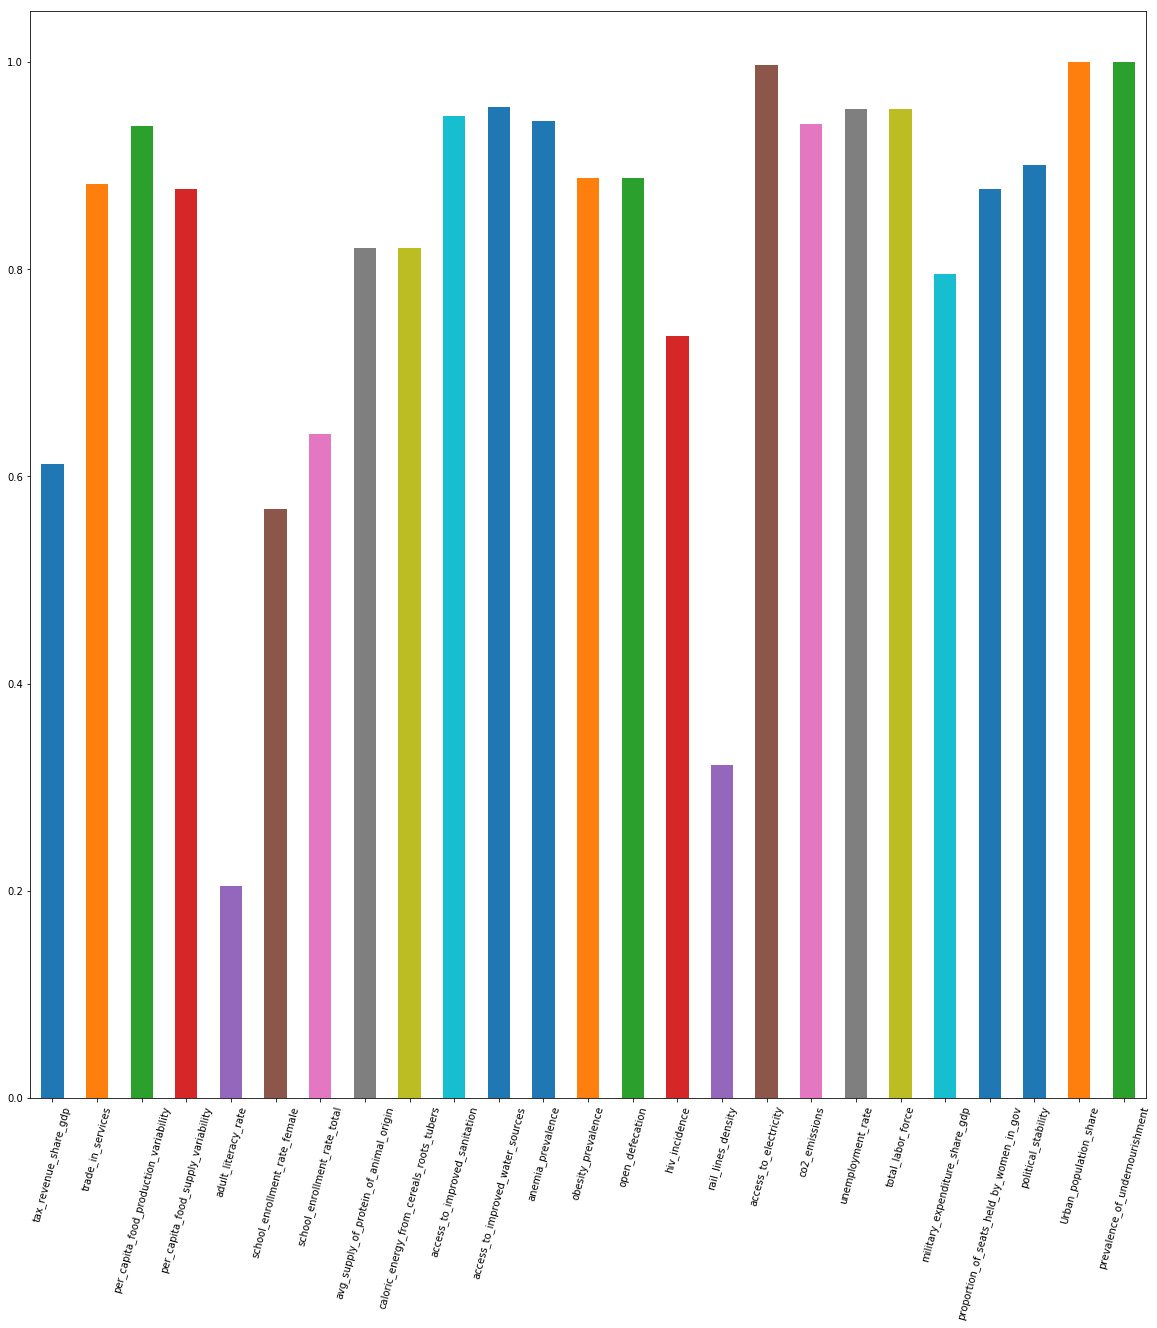

In [4]:
#determine which columns should be treated as categorical feature
fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)

(df.iloc[:,23:].apply(lambda x:x.unique().shape[0],axis=0)/df.shape[0]).plot(kind='bar',rot='75')
#上圖中，若欄位所對應的y值小，則代表該欄位的值有高度重複的現象。也就是說，該欄位可能為類別型變數。而若y值=1,則代表該欄位無重複值，有可能為索引或是連續型變數。

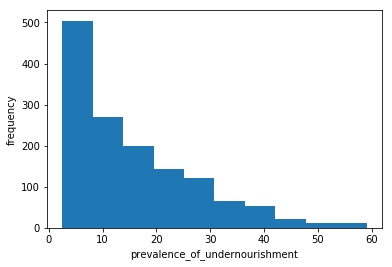

In [5]:
#ploting a histagram of undernourishment
plt.hist(df['prevalence_of_undernourishment'],bins=10)
plt.xlabel('prevalence_of_undernourishment')
plt.ylabel('frequency')
plt.show()

In [6]:
df['droughts_floods_extreme_temps']=df.droughts_floods_extreme_temps.fillna(0)

In [7]:
#checking columns have missing value
print(df.isnull().any().sum())


#drop columns if the missing value is over 40%
for i in df.columns:
    if df[i].isnull().sum()/df.shape[0] > 0.4:
        df=df.drop(columns=[i])
print(df.shape)

38
(1401, 44)


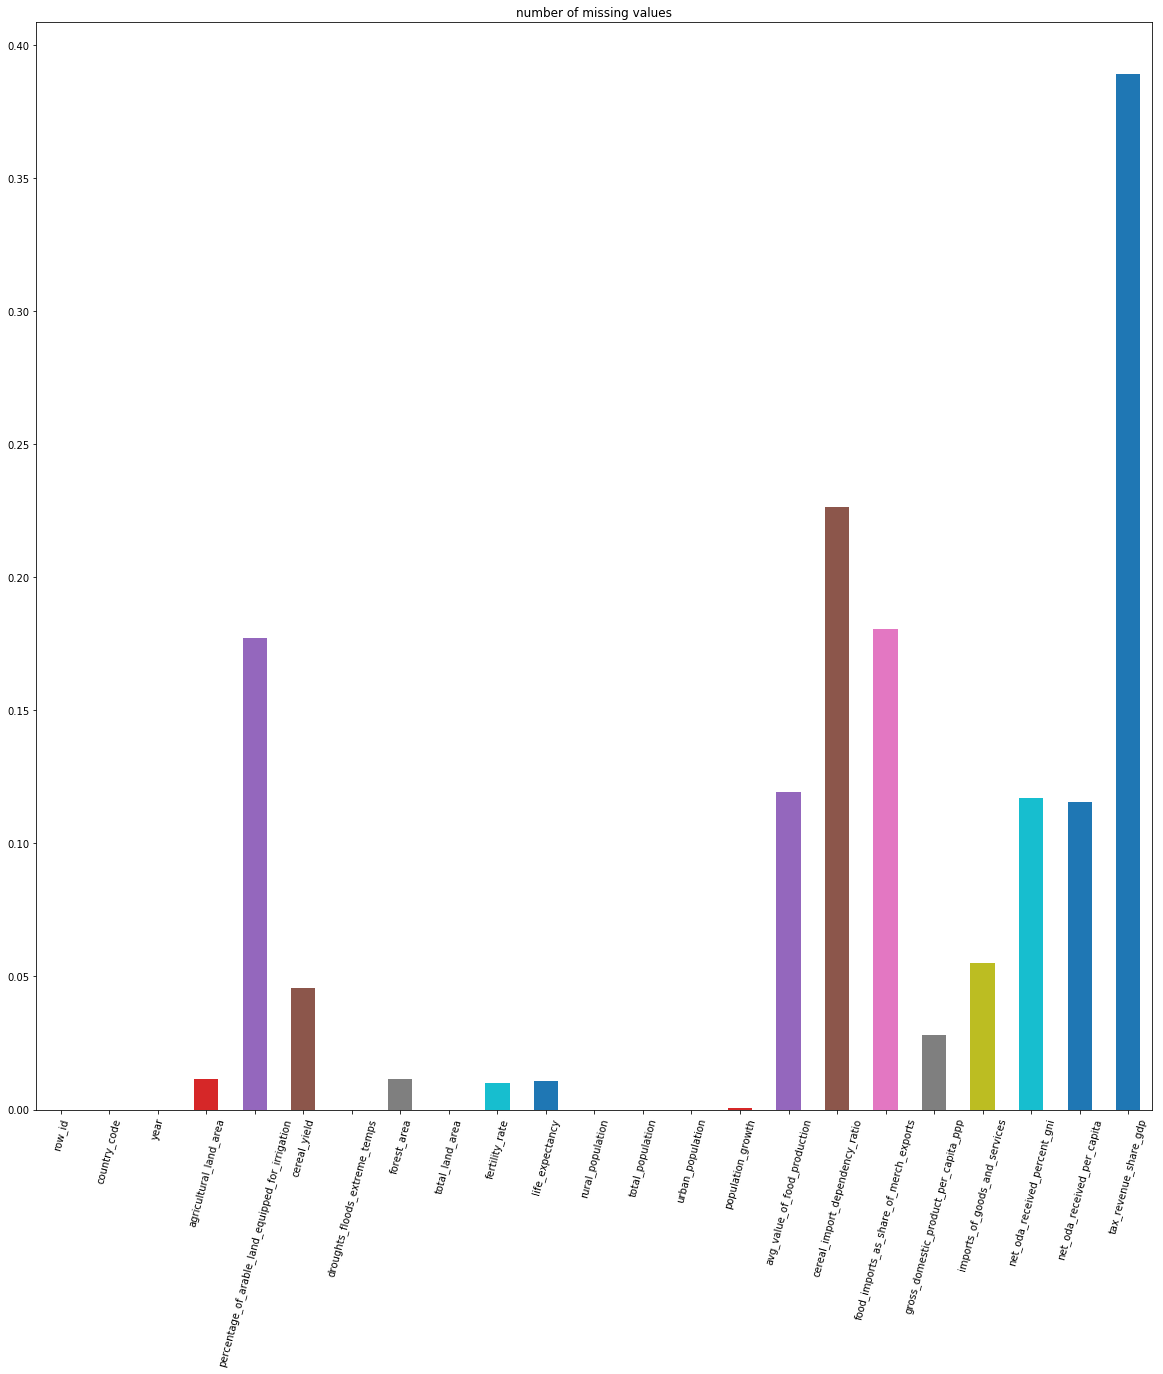

In [8]:
fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)

(df.iloc[:,:23].isnull().sum()/df.shape[0]).plot(kind='bar',rot=75,title='number of missing values')

In [9]:
#take out the columns that have less than 0.2 correlation with prevalence_of_undernourishment
df_new=pd.DataFrame(df.iloc[:,:2])
for i in df.columns[2:]:
    if abs(df['prevalence_of_undernourishment'].corr(df[i])) >0.2:
        df_new[i]=df[i]
df_new.shape

(1401, 22)

In [10]:
df_new.head()

,row_id,country_code,cereal_yield,fertility_rate,life_expectancy,population_growth,avg_value_of_food_production,gross_domestic_product_per_capita_ppp,net_oda_received_percent_gni,per_capita_food_production_variability,...,caloric_energy_from_cereals_roots_tubers,access_to_improved_sanitation,access_to_improved_water_sources,anemia_prevalence,obesity_prevalence,open_defecation,access_to_electricity,political_stability,Urban_population_share,prevalence_of_undernourishment
0,0,889f053,935.7544,5.9290,60.4522,2.8649,60.8913,3969.5191,2.2336,1.9681,...,64.1296,43.2865,57.9328,59.0614,8.2939,28.9335,52.4332,-1.3938,0.2691,31.2607
1,1,9e614ab,4031.4522,3.0006,64.6554,1.2999,266.0660,4527.2580,4.3513,4.9258,...,68.2857,63.5132,71.1207,36.9011,2.4833,29.6658,77.7156,0.0306,0.3516,18.2982
2,2,100c476,1581.9353,2.3019,74.3478,2.1500,111.6336,18513.5245,1.2824,2.1799,...,28.1107,85.8207,97.5873,27.2428,18.7264,1.3316,91.1510,0.6516,0.3195,39.5134
3,3,4609682,1127.6264,2.1993,74.6984,1.1857,334.2530,10710.2667,1.6282,15.7891,...,nan,92.2743,95.6115,29.0769,23.2185,1.5492,99.0304,-0.9288,0.6502,4.4440
4,4,be2a7f5,1418.9872,nan,nan,0.1736,365.2141,10416.0989,4.9007,23.7718,...,34.3266,nan,nan,25.0088,20.0108,7.5647,91.9304,0.9560,0.6696,4.9403


In [11]:
#fill the missing value
def fill_mean(df):
    fill_NaN = Imputer(missing_values=np.nan, strategy='median', axis=1)
    df_new=df.iloc[:,2:]
    imputed_DF = pd.DataFrame(fill_NaN.fit_transform(df_new))
    imputed_DF.columns = df_new.columns
    imputed_DF.index = df_new.index
    imputed_DF['country_code']=df['country_code']
    return imputed_DF
df_filled_mean=fill_mean(df_new)

def fill_ii(df):
    df_new=df.iloc[:,2:]
    df_filled_ii = pd.DataFrame(IterativeImputer().fit_transform(df_new.as_matrix()))
    df_filled_ii.columns = df_new.columns
    df_filled_ii.index = df_new.index
    df_filled_ii['country_code']=df['country_code']

    return df_filled_ii
df_filled_ii=fill_ii(df_new)

def fill_knn(df):
    df_new=df.iloc[:,2:]
    df_filled_knn =pd.DataFrame(KNN(k=5).fit_transform(df_new.as_matrix()))
    df_filled_knn.columns = df_new.columns
    df_filled_knn.index = df_new.index
    df_filled_knn['country_code']=df['country_code']

    return df_filled_knn
df_filled_knn=fill_knn(df_new)


df_filled_knn.isnull().any().any()

c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
c:\users\student\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
c:\users\student\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Imputing row 1/1401 with 1 missing, elapsed time: 0.390
Imputing row 101/1401 with 0 missing, elapsed time: 0.392
Imputing row 201/1401 with 3 missing, elapsed time: 0.395
Imputing row 301/1401 with 0 missing, elapsed time: 0.398
Imputing row 401/1401 with 0 missing, elapsed time: 0.400
Imputing row 501/1401 with 0 missing, elapsed time: 0.403
Imputing row 601/1401 with 1 missing, elapsed time: 0.406
Imputing row 701/1401 with 1 missing, elapsed time: 0.409
Imputing row 801/1401 with 0 missing, elapsed time: 0.413
Imputing row 901/1401 with 0 missing, elapsed time: 0.415
Imputing row 1001/1401 with 0 missing, elapsed time: 0.418
Imputing row 1101/1401 with 1 missing, elapsed time: 0.421
Imputing row 1201/1401 with 1 missing, elapsed time: 0.424
Imputing row 1301/1401 with 7 missing, elapsed time: 0.426
Imputing row 1401/1401 with 0 missing, elapsed time: 0.429


False

In [12]:
df_filled_knn.head(5)
# df_filled_knn.columns[2:]

,cereal_yield,fertility_rate,life_expectancy,population_growth,avg_value_of_food_production,gross_domestic_product_per_capita_ppp,net_oda_received_percent_gni,per_capita_food_production_variability,school_enrollment_rate_total,avg_supply_of_protein_of_animal_origin,...,access_to_improved_sanitation,access_to_improved_water_sources,anemia_prevalence,obesity_prevalence,open_defecation,access_to_electricity,political_stability,Urban_population_share,prevalence_of_undernourishment,country_code
0,935.7544,5.9290,60.4522,2.8649,60.8913,3969.5191,2.2336,1.9681,73.0393,11.0241,...,43.2865,57.9328,59.0614,8.2939,28.9335,52.4332,-1.3938,0.2691,31.2607,889f053
1,4031.4522,3.0006,64.6554,1.2999,266.0660,4527.2580,4.3513,4.9258,96.3925,14.0462,...,63.5132,71.1207,36.9011,2.4833,29.6658,77.7156,0.0306,0.3516,18.2982,9e614ab
2,1581.9353,2.3019,74.3478,2.1500,111.6336,18513.5245,1.2824,2.1799,88.1015,47.2033,...,85.8207,97.5873,27.2428,18.7264,1.3316,91.1510,0.6516,0.3195,39.5134,100c476
3,1127.6264,2.1993,74.6984,1.1857,334.2530,10710.2667,1.6282,15.7891,99.8371,44.7451,...,92.2743,95.6115,29.0769,23.2185,1.5492,99.0304,-0.9288,0.6502,4.4440,4609682
4,1418.9872,1.8444,78.9388,0.1736,365.2141,10416.0989,4.9007,23.7718,88.0824,51.5860,...,97.0269,98.5530,25.0088,20.0108,7.5647,91.9304,0.9560,0.6696,4.9403,be2a7f5


In [13]:
df_filled_knn.shape

(1401, 21)

Text(0.5, 1.0, 'Correlation between features')

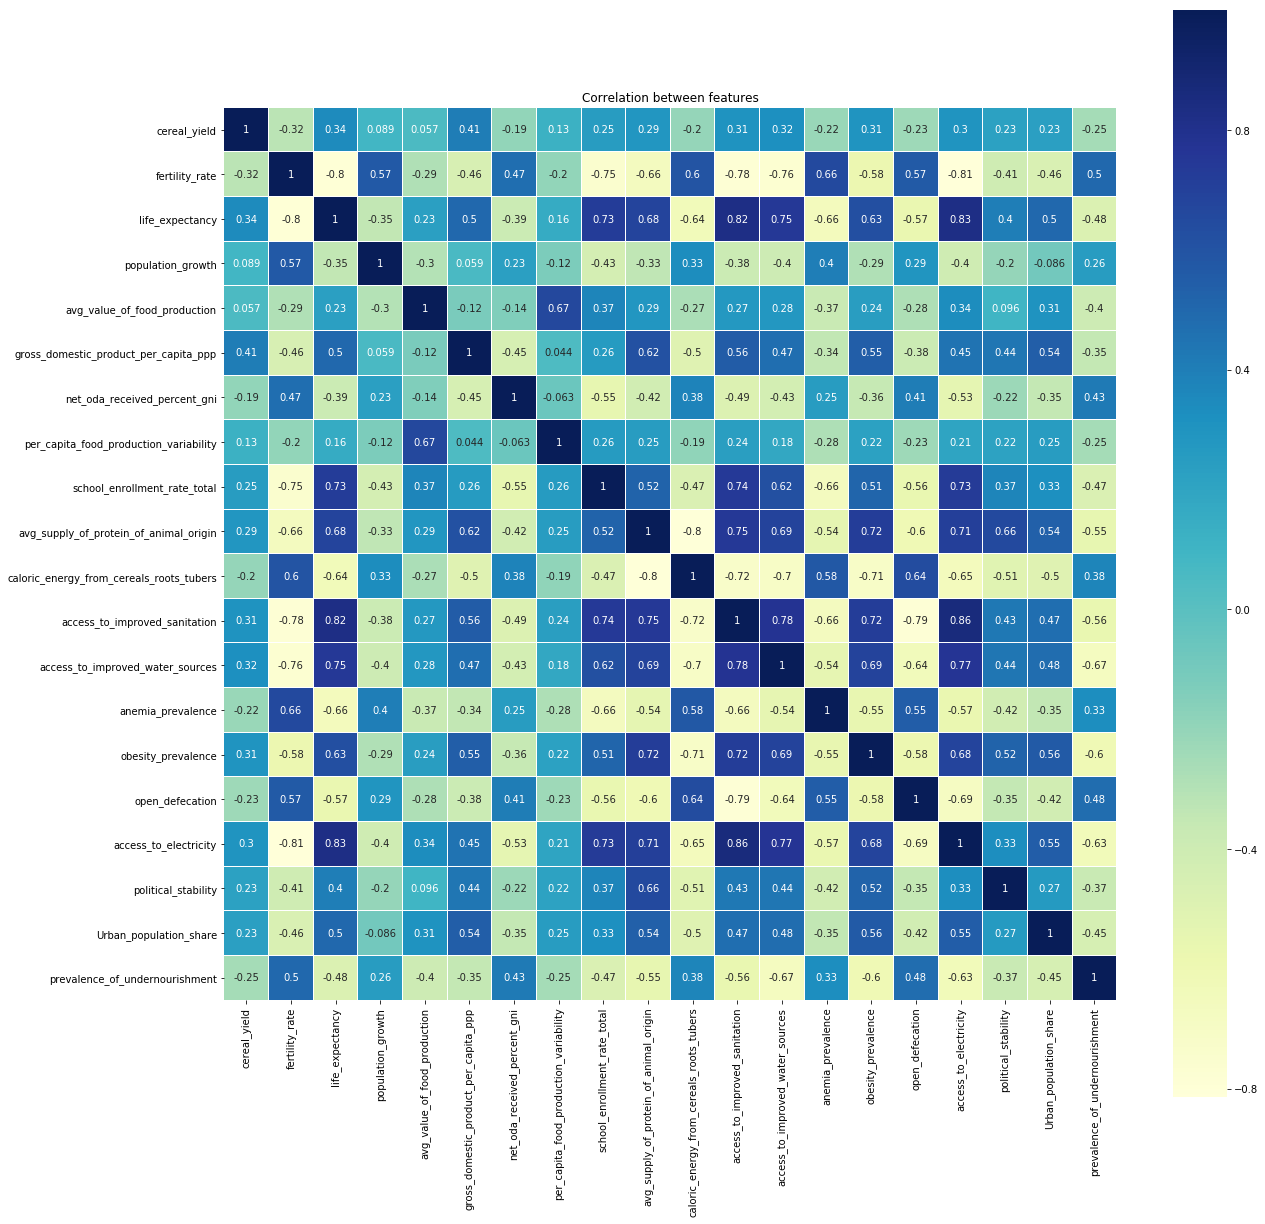

In [14]:
fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)

g=sns.heatmap(df_filled_ii.corr(), vmax=1, linewidths=0.01,
            square=True,annot=True,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features')

In [15]:
#drop some columns to prevent the multicollinearity effect
df_filled_knn=df_filled_knn.drop(columns=['access_to_improved_sanitation','access_to_electricity','life_expectancy'])

In [16]:
# df_filled_knn.to_csv('train_x_new.csv', encoding='utf8', index=False)

In [17]:
df_filled_ii=df_filled_ii.drop(columns=['access_to_improved_sanitation','access_to_electricity','life_expectancy','population_growth'])

# df_filled_knn=df_filled_knn.drop(columns=[])

In [18]:
df_filled_knn.shape

(1401, 18)

In [19]:
#using df_filled_knn to generate train/test dataset
country_list=df['country_code'].unique()

country_list_df = pd.DataFrame(country_list)

train_list=country_list_df.sample(frac=0.7)
test_list=country_list_df.drop(train_list.index)

train=df_filled_knn[df_filled_knn.country_code.isin(list(train_list.iloc[:,0])) ]

test=df_filled_knn[df_filled_knn.country_code.isin(list(test_list.iloc[:,0])) ]

In [20]:
#using df_filled_ii to generate train/test dataset

country_list=df['country_code'].unique()

country_list_df = pd.DataFrame(country_list)

train_list=country_list_df.sample(frac=0.7)
test_list=country_list_df.drop(train_list.index)

train=df_filled_ii[df_filled_ii.country_code.isin(list(train_list.iloc[:,0])) ]

test=df_filled_ii[df_filled_ii.country_code.isin(list(test_list.iloc[:,0])) ]

In [21]:
#split train test data
def dfXYSplit(df,targetName):
    
    dfX=df.drop(columns=targetName)
    dfY=df[targetName]
    return dfX,dfY
trainX,trainY=dfXYSplit(train,"prevalence_of_undernourishment")
testX,testY=dfXYSplit(test,"prevalence_of_undernourishment")

In [22]:
trainX=trainX.drop(columns=['country_code'])
trainY=trainY.drop(columns=['country_code'])
testX=testX.drop(columns=['country_code'])
testY=testY.drop(columns=['country_code'])

In [23]:
xgb_reg = XGBRegressor(n_estimators=100, max_depth=10,learning_rate=0.01,random_state=100,subsample=0.8)
# rfecv =   RFECV(estimator=xgb_reg, cv=10, scoring='mean_squared_error')
# trainX=rfecv.fit_transform(trainX,trainY)
params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(6,11)],
'colsample_bytree':[i/10.0 for i in range(6,11)], 'max_depth': [2,3,4]}
grid = GridSearchCV(xgb_reg, params,scoring='neg_mean_squared_error',cv=5)
grid.fit(trainX, trainY)

y_pred = grid.predict(testX)
print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(testY, y_pred))))


Root Mean Square Error = 9.707208305086432


c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [24]:
#random forest regressor 
rf = RandomForestRegressor()
param_grid = { 
'bootstrap': [True],
'max_depth': [80, 90, 100, 110],
'max_features': [2, 3],
'min_samples_leaf': [3, 4, 5],
'min_samples_split': [8, 10, 12],
'n_estimators': [100, 200, 300, 1000]
            }

grid_rf = GridSearchCV(rf, param_grid, n_jobs=-1, cv=5)

grid_rf.fit(trainX, trainY)

y_pred = grid_rf.predict(testX)

print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(testY, y_pred))))

c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\tree\tree.py:179: DeprecationWarning: 'min_samples_leaf' is deprecated in 0.20 and will be fixed to a value of 1 in 0.22.
  DeprecationWarning)
c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\tree\tree.py:179: DeprecationWarning: 'min_samples_leaf' is deprecated in 0.20 and will be fixed to a value of 1 in 0.22.
  DeprecationWarning)
c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\tree\tree.py:179: DeprecationWarning: 'min_samples_leaf' is deprecated in 0.20 and will be fixed to a value of 1 in 0.22.
  DeprecationWarning)
c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\tree\tree.py:179: DeprecationWarning: 'min_samples_leaf' is deprecated in 0.20 and will be fixed to a value of 1 in 0.22.
  DeprecationWarning)
c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\tree\tree.py:1

c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\tree\tree.py:179: DeprecationWarning: 'min_samples_leaf' is deprecated in 0.20 and will be fixed to a value of 1 in 0.22.
  DeprecationWarning)
c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\tree\tree.py:179: DeprecationWarning: 'min_samples_leaf' is deprecated in 0.20 and will be fixed to a value of 1 in 0.22.
  DeprecationWarning)
c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\tree\tree.py:179: DeprecationWarning: 'min_samples_leaf' is deprecated in 0.20 and will be fixed to a value of 1 in 0.22.
  DeprecationWarning)
c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\tree\tree.py:179: DeprecationWarning: 'min_samples_leaf' is deprecated in 0.20 and will be fixed to a value of 1 in 0.22.
  DeprecationWarning)
c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\tree\tree.py:1

c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\tree\tree.py:179: DeprecationWarning: 'min_samples_leaf' is deprecated in 0.20 and will be fixed to a value of 1 in 0.22.
  DeprecationWarning)
c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\tree\tree.py:179: DeprecationWarning: 'min_samples_leaf' is deprecated in 0.20 and will be fixed to a value of 1 in 0.22.
  DeprecationWarning)
c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\tree\tree.py:179: DeprecationWarning: 'min_samples_leaf' is deprecated in 0.20 and will be fixed to a value of 1 in 0.22.
  DeprecationWarning)
c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\tree\tree.py:179: DeprecationWarning: 'min_samples_leaf' is deprecated in 0.20 and will be fixed to a value of 1 in 0.22.
  DeprecationWarning)
c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\tree\tree.py:1

c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\tree\tree.py:179: DeprecationWarning: 'min_samples_leaf' is deprecated in 0.20 and will be fixed to a value of 1 in 0.22.
  DeprecationWarning)
c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\tree\tree.py:179: DeprecationWarning: 'min_samples_leaf' is deprecated in 0.20 and will be fixed to a value of 1 in 0.22.
  DeprecationWarning)
c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\tree\tree.py:179: DeprecationWarning: 'min_samples_leaf' is deprecated in 0.20 and will be fixed to a value of 1 in 0.22.
  DeprecationWarning)
c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\tree\tree.py:179: DeprecationWarning: 'min_samples_leaf' is deprecated in 0.20 and will be fixed to a value of 1 in 0.22.
  DeprecationWarning)
c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\tree\tree.py:1

c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\tree\tree.py:179: DeprecationWarning: 'min_samples_leaf' is deprecated in 0.20 and will be fixed to a value of 1 in 0.22.
  DeprecationWarning)
c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\tree\tree.py:179: DeprecationWarning: 'min_samples_leaf' is deprecated in 0.20 and will be fixed to a value of 1 in 0.22.
  DeprecationWarning)
c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\tree\tree.py:179: DeprecationWarning: 'min_samples_leaf' is deprecated in 0.20 and will be fixed to a value of 1 in 0.22.
  DeprecationWarning)
c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\tree\tree.py:179: DeprecationWarning: 'min_samples_leaf' is deprecated in 0.20 and will be fixed to a value of 1 in 0.22.
  DeprecationWarning)
c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\tree\tree.py:1

c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\tree\tree.py:179: DeprecationWarning: 'min_samples_leaf' is deprecated in 0.20 and will be fixed to a value of 1 in 0.22.
  DeprecationWarning)
c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\tree\tree.py:179: DeprecationWarning: 'min_samples_leaf' is deprecated in 0.20 and will be fixed to a value of 1 in 0.22.
  DeprecationWarning)
c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\tree\tree.py:179: DeprecationWarning: 'min_samples_leaf' is deprecated in 0.20 and will be fixed to a value of 1 in 0.22.
  DeprecationWarning)
c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\tree\tree.py:179: DeprecationWarning: 'min_samples_leaf' is deprecated in 0.20 and will be fixed to a value of 1 in 0.22.
  DeprecationWarning)
c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\tree\tree.py:1

c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\tree\tree.py:179: DeprecationWarning: 'min_samples_leaf' is deprecated in 0.20 and will be fixed to a value of 1 in 0.22.
  DeprecationWarning)
c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\tree\tree.py:179: DeprecationWarning: 'min_samples_leaf' is deprecated in 0.20 and will be fixed to a value of 1 in 0.22.
  DeprecationWarning)
c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\tree\tree.py:179: DeprecationWarning: 'min_samples_leaf' is deprecated in 0.20 and will be fixed to a value of 1 in 0.22.
  DeprecationWarning)
c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\tree\tree.py:179: DeprecationWarning: 'min_samples_leaf' is deprecated in 0.20 and will be fixed to a value of 1 in 0.22.
  DeprecationWarning)
c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\tree\tree.py:1

Root Mean Square Error = 9.046666294227649


c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\tree\tree.py:179: DeprecationWarning: 'min_samples_leaf' is deprecated in 0.20 and will be fixed to a value of 1 in 0.22.
  DeprecationWarning)
c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\tree\tree.py:179: DeprecationWarning: 'min_samples_leaf' is deprecated in 0.20 and will be fixed to a value of 1 in 0.22.
  DeprecationWarning)
c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\tree\tree.py:179: DeprecationWarning: 'min_samples_leaf' is deprecated in 0.20 and will be fixed to a value of 1 in 0.22.
  DeprecationWarning)
c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\tree\tree.py:179: DeprecationWarning: 'min_samples_leaf' is deprecated in 0.20 and will be fixed to a value of 1 in 0.22.
  DeprecationWarning)
c:\users\student\appdata\local\programs\python\python36\lib\site-packages\sklearn\tree\tree.py:1

In [25]:
#read private set data, predict label
df_test=pd.read_csv('../data/test_values_K7FqC54.csv')
df_test['Urban_population_share']=df_test['urban_population']/df_test['total_population']
df_test_new=pd.DataFrame(df_test['row_id'])
for i in trainX.columns:
    df_test_new[i]=df_test[i]


    
df_test_new=df_test_new.drop(columns=['row_id'])
df_test_new =pd.DataFrame(KNN(k=5).fit_transform(df_test_new.as_matrix()))
df_test_new.columns = df_test_new.columns
df_test_new.index = df_test_new.index
df_test_new.head()

c:\users\student\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


Imputing row 1/616 with 1 missing, elapsed time: 0.073
Imputing row 101/616 with 0 missing, elapsed time: 0.076
Imputing row 201/616 with 0 missing, elapsed time: 0.079
Imputing row 301/616 with 1 missing, elapsed time: 0.081
Imputing row 401/616 with 6 missing, elapsed time: 0.083
Imputing row 501/616 with 0 missing, elapsed time: 0.085
Imputing row 601/616 with 5 missing, elapsed time: 0.087


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,4494.9185,2.9038,115.4277,43451.5186,0.3801,7.3785,97.8471,45.1436,38.3563,94.8324,36.0571,21.7798,1.0631,0.4555,0.7561
1,4319.5040,1.6502,358.8888,9685.4105,3.0312,6.1896,86.1273,53.9503,39.4578,94.5649,22.3787,15.5163,0.4407,-0.0499,0.4977
2,5228.8692,2.4253,164.9787,10170.2830,-0.0041,30.5180,91.0379,54.2419,31.5430,85.7732,27.9245,15.0833,12.3855,-0.6102,0.5247
3,784.2919,4.0003,93.1382,1911.0728,3.3696,10.9443,85.1132,9.8532,56.0498,78.7009,34.6311,8.6087,28.2810,-1.1158,0.3356
4,1239.7896,4.0416,199.6912,1921.9589,11.5604,14.1189,90.3106,35.3549,38.3547,60.5495,25.9028,32.3710,48.2985,0.7785,0.4401


In [26]:
# df_test_new.to_csv('test_x_new.csv', encoding='utf8', index=False)

In [28]:
y_pred_private=xgb_reg.predict(df_test_new)

XGBoostError: need to call fit or load_model beforehand

In [ ]:
y_pred_private=grid_rf.predict(df_test_new)

In [ ]:
#export file as csv
import csv
with open('sumbit11.csv', 'w',newline='') as f:
    writer = csv.writer(f)
    for i in y_pred_private:
        writer.writerow([i])
    

## Missing Value Impute
* MICE,KNN:https://stackoverflow.com/questions/45239256/data-imputation-with-fancyimpute-and-pandas
* Gaussian-mixture: https://github.com/pmelchior/pygmmis

## Feature Selection
* step wise: https://datascience.stackexchange.com/questions/937/does-scikit-learn-have-forward-selection-stepwise-regression-algorithm
* rff: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html



## Model Improvement
* merge column:Urban population share(i.e. total urban population / total population), 
* feature selection: rff
* revise the collinarity 
* train/test split by country
* different model: random forest regressor


